In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import nrrd
import json
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi
import requests
from anatomy.anatomy_api import AnatomyApi
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from scipy.optimize import curve_fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.graphics import utils
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
import scipy

import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
aapi = AnatomyApi()
ss = aapi.get_summary_structure_data('id')
mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()
isocortex = structure_tree.get_structures_by_acronym(['Isocortex'])[0]
cla = structure_tree.get_structures_by_acronym(['CLA'])[0]['id']
HPF = structure_tree.get_structures_by_acronym(['HPF'])[0]
iso = structure_tree.descendant_ids([isocortex['id']])[0]
iso = [structure for structure in iso if structure in ss]
hipp = structure_tree.descendant_ids([HPF['id']])[0]
hipp = [structure for structure in hipp if structure in ss]
ia_map = structure_tree.get_id_acronym_map()
ai_map = {value:key for key, value in ia_map.items()}
ctx_strs = [ai_map[structure] for structure in iso]
hipp_strs = [ai_map[structure] for structure in hipp]
valid_strs = ctx_strs#+hipp_strs #No Cla

In [3]:
import platform
if platform.system() == 'Darwin':
    basepath = r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN'
if platform.system() == 'Windows':
    basepath = r'C:\Users\jenniferwh\Dropbox (Allen Institute)\Mesoscale Connectome Papers in Progress\2019 DMN'

datpath = os.path.join(basepath, 'data_files')
savepath = os.path.join(basepath, '_new_figures', 'Figure_4')
full_td_dataset = pd.read_csv(os.path.join(basepath, 'target_defined_dataset.csv'))
td_exps = full_td_dataset[full_td_dataset['include'] == 'yes']
td_exps.rename(columns = {'image_series_id': 'id'}, inplace = True)
print(len(full_td_dataset))
print(len(td_exps))

183
121


/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [4]:
iso = structure_tree.get_structures_by_acronym(['Isocortex'])[0] # get a 100 um isocortex mask
ctx_exps = pd.DataFrame(mcc.get_experiments(cre=False, 
                                       injection_structure_ids=[iso['id']]))
cre_experiments = pd.DataFrame(mcc.get_experiments(cre=['Emx1-IRES-Cre','Rbp4-Cre_KL100'],
                                      injection_structure_ids = [iso['id']]))
ctx_exps = pd.concat([ctx_exps, cre_experiments])

In [5]:
c_by_source = pd.read_csv(os.path.join(datpath, 'good_wt_correlations.csv'))
print(len(c_by_source))
alldat = pd.read_csv(os.path.join(datpath, 'good_td_wt_correlations.csv'))
print(len(alldat))
td_dat = pd.read_csv(os.path.join(datpath, 'good_td_td_correlations.csv'))
print(len(td_dat))

627
586
241


In [6]:
all_isids = np.unique(np.concatenate((c_by_source['match_A'].unique(), c_by_source['match_B'].unique())))

In [7]:
print(len([isid for isid in alldat['match_id'].unique() if isid in all_isids]))
print(len([isid for isid in alldat['match_id'].unique() if isid not in all_isids]))

108
20


In [8]:
print(len(alldat['match_id'].unique()))

128


In [9]:
with open(os.path.join(savepath, 'curated_matches.json'), 'r') as jsonfile:
    groups = json.load(jsonfile)
groups = pd.DataFrame(groups)

In [10]:
all_td_exps = list(groups['td_sets'].values)
all_td_exps = set([item for sublist in all_td_exps for item in sublist])
print(len(all_td_exps))
all_wt_exps = list(groups['wt_sets'].values)
all_wt_exps = set([item for sublist in all_wt_exps for item in sublist])
print(len(all_wt_exps))

63
34


In [11]:
ctx_glm_dat = pd.read_csv(os.path.join(datpath,
                                       'wt_cre_ctx_injections_DMN_and_core_projections_coefficients.csv'))
td_glm_dat = pd.read_csv(os.path.join(datpath,
                                       'td_ctx_injections_DMN_and_core_projections_coefficients.csv'))
td_glm_dat.rename(columns = {'image_series_id': 'id'}, inplace = True)
ctx_coord_dat = pd.read_csv(os.path.join(datpath,
                                         'cortical_flatmap_coordinates.csv'))

In [12]:
ctx_coord_dat.head()

,flat_x,top_x,flat_y,id,top_y
0,173.0,335.0,885.0,528328648.0,633.0
1,634.0,297.0,1090.0,515920693.0,914.0
2,359.0,724.0,875.0,112935169.0,548.0
3,1111.0,412.0,640.0,267749107.0,447.0
4,672.0,281.0,914.0,657334568.0,736.0


In [13]:
wt = ctx_glm_dat[ctx_glm_dat['id'].isin(all_wt_exps)]
td = td_glm_dat[td_glm_dat['id'].isin(all_td_exps)]
wt = wt.merge(ctx_coord_dat[['id', 'top_x', 'top_y', 'flat_x', 'flat_y']], 
                              on = 'id', how = 'left')
td = td.merge(ctx_coord_dat[['id', 'top_x', 'top_y', 'flat_x', 'flat_y']], 
                              on = 'id', how = 'left')
print(len(wt))
print(len(td))

34
63


In [14]:
print(wt['id'].unique())

[126861679 139426984 100148503 112229103 112595376 112423392 112306316
 157711748 158435116 307593747 100141219 112424813 593018150 526783054
 518742338 125833030 480994108 287769286 478491090 266250195 584895127
 576341623 479755622 575782182 524667618 478376911 156741826 159753308
 121510421 646525156 482580380 496576666 263106036 562674923]


In [15]:
print(wt[wt['flat_x'].isnull()]['id'].values)
print(td[td['flat_x'].isnull()]['id'].values)

[]
[]


In [16]:
td = td.merge(td_exps[['id', 'CAV_percent_DMN']])

In [24]:
both = pd.concat([td, wt])

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [99]:
import imageio
imb = imageio.imread(os.path.join(savepath, 'FlatmapAreaBoundaries.png'))

In [100]:
imb.shape

(1365, 1200, 4)

In [67]:
mean_x = both.groupby('injection structure').mean()['flat_x'].round()
mean_y = both.groupby('injection structure').mean()['flat_y'].round()
print(mean_x)
print(mean_y)

injection structure
ACAd      1076.0
ORBl       849.0
ORBvl      902.0
PL        1134.0
RSPagl     828.0
RSPd       921.0
RSPv      1024.0
VISam      783.0
VISl       480.0
VISp       640.0
Name: flat_x, dtype: float64
injection structure
ACAd       686.0
ORBl       144.0
ORBvl      117.0
PL         421.0
RSPagl     978.0
RSPd      1042.0
RSPv      1200.0
VISam      962.0
VISl      1063.0
VISp      1098.0
Name: flat_y, dtype: float64


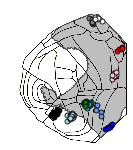

In [101]:
fig,ax = plt.subplots(figsize = (2.5, 2.5))
ax.imshow(imb)
cax = ax.scatter(both[both['injection structure'] == 'VISp'].flat_x,
           both[both['injection structure'] == 'VISp'].flat_y,
           c = 'lightblue',
           edgecolor = 'k',
           s = 25,
                label = 'TD, in-DMN Target',
                zorder = 2)
cax = ax.scatter(both[both['injection structure'] == 'VISl'].flat_x,
           both[both['injection structure'] == 'VISl'].flat_y,
           c = 'k',
           edgecolor = 'k',
           s = 25,
                label = 'TD, in-DMN Target',
                zorder = 2)
cax = ax.scatter(both[both['injection structure'] == 'ORBl'].flat_x,
           both[both['injection structure'] == 'ORBl'].flat_y,
           c = 'gray',
           edgecolor = 'k',
           s = 25,
                label = 'TD, in-DMN Target',
                zorder = 2)
cax = ax.scatter(both[both['injection structure'] == 'ORBvl'].flat_x,
           both[both['injection structure'] == 'ORBvl'].flat_y,
           c = 'w',
           edgecolor = 'k',
           s = 25,
                label = 'TD, in-DMN Target',
                zorder = 2)
cax = ax.scatter(both[both['injection structure'] == 'PL'].flat_x,
           both[both['injection structure'] == 'PL'].flat_y,
           c = 'r',
           edgecolor = 'k',
           s = 25,
                label = 'TD, in-DMN Target',
                zorder = 2)
cax = ax.scatter(both[both['injection structure'] == 'ACAd'].flat_x,
           both[both['injection structure'] == 'ACAd'].flat_y,
           c = 'pink',
           edgecolor = 'k',
           s = 25,
                label = 'TD, in-DMN Target',
                zorder = 2)
cax = ax.scatter(both[both['injection structure'] == 'RSPv'].flat_x,
           both[both['injection structure'] == 'RSPv'].flat_y,
           c = 'b',
           edgecolor = 'k',
           s = 25,
                label = 'TD, in-DMN Target',
                zorder = 2)
cax = ax.scatter(both[both['injection structure'] == 'RSPd'].flat_x,
           both[both['injection structure'] == 'RSPd'].flat_y,
           c = 'cornflowerblue',
           edgecolor = 'k',
           s = 25,
                label = 'TD, in-DMN Target',
                zorder = 2)
cax = ax.scatter(both[both['injection structure'] == 'RSPagl'].flat_x,
           both[both['injection structure'] == 'RSPagl'].flat_y,
           c = 'c',
           edgecolor = 'k',
           s = 25,
                label = 'TD, in-DMN Target',
                zorder = 2)
cax = ax.scatter(both[both['injection structure'] == 'VISam'].flat_x,
           both[both['injection structure'] == 'VISam'].flat_y,
           c = 'g',
           edgecolor = 'k',
           s = 25,
                label = 'TD, in-DMN Target',
                zorder = 2)
ax.set_aspect('equal')
plt.axis('off')
plt.savefig(os.path.join(savepath, 'td_injections_matched_with_wt_flat_map_colors.pdf'), 
            bbox_inches='tight', format='pdf', transparent=True, dpi=300)

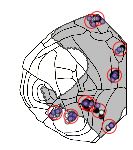

In [138]:
td_exps.sort_values(by='injection_volume')
fig,ax = plt.subplots(figsize = (2.5, 2.5))
ax.imshow(imb)
cax = ax.scatter(td[(td['CAV_percent_DMN'] > 50)].flat_x,
           td[(td['CAV_percent_DMN'] > 50)].flat_y,
           c = 'mediumpurple',
           edgecolor = 'k',
           s = 25,
                label = 'TD, in-DMN Target',
                zorder = 3,
                alpha = 0.7)
cax = ax.scatter(td[(td['CAV_percent_DMN'] < 50)].flat_x,
           td[(td['CAV_percent_DMN'] < 50)].flat_y,
           c = 'w',
           edgecolor = 'k',
           s = 25,
                label = 'TD, out-DMN Target',
                alpha = 0.8,
                zorder = 2)
cax = ax.scatter(wt.flat_x,
           wt.flat_y,
           c = 'k',
           edgecolor = 'k',
           s = 25,
                label = 'Matched WT',
                zorder = 1)
cax = ax.scatter(mean_x,
                mean_y,
                 c = 'None',
                 edgecolor = 'r',
                 s= 200,
                 zorder = 2)
'''
legend = plt.legend(frameon = False, fontsize = 8, loc = 1, bbox_to_anchor = [0.9,0.23],
                   labelspacing = 0.2)
legend.legendHandles[0]._sizes = [20]
legend.legendHandles[1]._sizes = [20]
legend.legendHandles[2]._sizes = [20]
'''
ax.set_aspect('equal')
plt.axis('off')
plt.savefig(os.path.join(savepath, 'td_injections_matched_with_wt_flat_map.pdf'), 
            bbox_inches='tight', format='pdf', transparent=True, dpi=300)

(-0.5, 1199.5, 1364.5, -0.5)

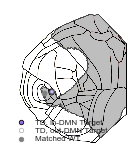

In [103]:
fig,ax = plt.subplots(figsize = (2.5, 2.5))
ax.imshow(imb)
pltdat = td[td['injection structure'] == 'RSPv']
cax = ax.scatter(pltdat[(pltdat['CAV_percent_DMN'] > 50)].top_x,
           pltdat[(pltdat['CAV_percent_DMN'] > 50)].top_y,
           c = 'mediumpurple',
           edgecolor = 'k',
           s = 25,
                label = 'TD, in-DMN Target',
                zorder = 2)
cax = ax.scatter(pltdat[(pltdat['CAV_percent_DMN'] < 50)].top_x,
           pltdat[(pltdat['CAV_percent_DMN'] < 50)].top_y,
           c = 'w',
           edgecolor = 'k',
           s = 25,
                label = 'TD, out-DMN Target',
                zorder = 3,
                alpha = 0.3)
cax = ax.scatter(wt[wt['injection structure'] == 'RSPv'].top_x,
           wt[wt['injection structure'] == 'RSPv'].top_y,
           c = 'gray',
           edgecolor = 'gray',
           s = 25,
                label = 'Matched WT',
                zorder = 1)
legend = plt.legend(frameon = False, fontsize = 8, loc = 1, bbox_to_anchor = [0.9,0.23],
                   labelspacing = 0.2)
legend.legendHandles[0]._sizes = [20]
legend.legendHandles[1]._sizes = [20]
legend.legendHandles[2]._sizes = [20]
ax.set_aspect('equal')
plt.axis('off')

In [104]:
pltdat['id'].unique()

array([521255975, 592522663, 623838656, 664716091, 569904687, 868641659,
       592724077, 666090944])

In [105]:
td_exps[td_exps['id'].isin(pltdat['id'].unique())][['id', 'target_by_polygon']]

,id,target_by_polygon
29,521255975,ACAd
70,569904687,VISl
92,592522663,PL
93,592724077,VISpl
112,623838656,PL
118,664716091,RSPd
119,666090944,VISpl
120,868641659,VISp


## Boxplots by source

In [106]:
plot_order = ['ACAd', 'PL', 'ORBl', 'ORBvl', 
              'VISam', 'RSPd', 'RSPv', 'RSPagl', 
             'VISl', 'VISp']
print([source for source in groups['source'].values if source not in plot_order])

[]


In [107]:
dmn_colors = {'in':'mediumpurple', 'out': 'w'}

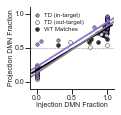

In [140]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.regplot(x = 'injection dmn fraction',
            y = 'projection dmn fraction',
            data = wt,
            ax = ax,
            color = 'k',
            ci = False,
            scatter_kws={'s':15,
                        'linewidth':0.5},
           label = 'WT Matches')
sns.regplot(x = 'injection dmn fraction',
            y = 'projection dmn fraction',
            data = td[td['CAV_percent_DMN'] < 50],
            ax = ax,
            ci = False,
            color = dmn_colors['out'],
            scatter_kws={'s':15,
                         'edgecolor': 'k',
                        'linewidth':0.5},
            line_kws={'color':'gray'},
           label = 'TD (out-target)')
sns.regplot(x = 'injection dmn fraction',
            y = 'projection dmn fraction',
            data = td[td['CAV_percent_DMN'] > 50],
            ax = ax,
            color = dmn_colors['in'],
            ci=False,
            scatter_kws={'s':12,
                        'edgecolor': 'k',
                        'linewidth':0.5},
           label = 'TD (in-target)')
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
plt.xticks([0, 0.5, 1], fontsize = 7)
plt.yticks([0, 0.5, 1], fontsize = 7)
ax.set_ylabel('Projection DMN Fraction', fontsize = 7)
ax.xaxis.labelpad = 1
ax.yaxis.labelpad = 1
ax.set_xlabel('Injection DMN Fraction', fontsize = 7)
ax.axhline(y = 0.5, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
handles, labels = ax.get_legend_handles_labels()
order = [2, 1, 0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          loc = 2, fontsize = 6, frameon = False,
          bbox_to_anchor = [-0.05, 1], handletextpad=0.1,
          labelspacing = 0.3)
sns.despine()
ax.tick_params(top = False, right = False, bottom = True, left = True, pad = 1)
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)

plt.savefig(os.path.join(savepath, 'td_matched_wt_injection_projection_DMN_fraction.pdf'), 
            bbox_inches='tight', transparent=True, dpi=300)

In [109]:
pltdat = pd.concat([wt, td], sort=True)

In [110]:
pltdat.keys()

Index(['CAV_percent_DMN', 'DMN coefficient', 'DMN core coefficient',
       'DMN p values', 'DMN t values', 'core distance coefficient',
       'core p values', 'core t values', 'distance coefficient', 'flat_x',
       'flat_y', 'id', 'injection core fraction', 'injection dmn fraction',
       'injection structure', 'projection core fraction',
       'projection dmn fraction', 'top_x', 'top_y'],
      dtype='object')

In [111]:
full_td_dataset.keys()

Index(['image_series_id', 'specimen_name', 'sex', 'age_at_injection',
       'injection_structures', 'injection_volume',
       'primary_injection_structure', 'source', 'structure_id',
       'target_by_polygon', 'include', 'exclusion reason',
       'cortical_projection_view', 'experiment_detail_page',
       'injection dmn fraction', 'projection dmn fraction',
       'distance coefficient', 'DMN coefficient', 'CAV_percent_DMN',
       'WT_matches', 'TD_matches', 'injection_matched_group'],
      dtype='object')

In [112]:
full_td_dataset['injection_matched_group'] = np.nan
full_td_dataset['injection_matched_group'] = full_td_dataset[
    'injection_matched_group'].astype('object')
matches_per_isid = dict()
for source in pltdat['injection structure'].unique():
    print(source)
    dataset = list(pltdat[pltdat['injection structure'] == source]['id'].unique())
    for isid in full_td_dataset['image_series_id'].unique():
        if isid in dataset:
            matches_per_isid[isid] = dataset

VISam
ACAd
RSPagl
RSPv
ORBvl
ORBl
PL
VISp
RSPd
VISl


In [113]:
matched_sets = []
for isid in full_td_dataset['image_series_id'].unique():
    if isid in matches_per_isid.keys():
        matched_sets.append(matches_per_isid[isid])
    else:
        matched_sets.append([np.nan])
full_td_dataset['injection_matched_group'] = matched_sets

In [114]:
#full_td_dataset.to_csv(r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/target_defined_dataset.csv',
#                     index = False)

In [115]:
pltdat.loc[pltdat['injection dmn fraction'] < 0.5, 'dmn_by_ol'] = 'out'
pltdat.loc[pltdat['injection dmn fraction'] > 0.5, 'dmn_by_ol'] = 'in'

In [116]:
pltdat.loc[pltdat['CAV_percent_DMN'].isnull(), 'expt_type'] = 'WT'
pltdat.loc[pltdat['CAV_percent_DMN'] < 50, 'expt_type'] = 'out_target'
pltdat.loc[pltdat['CAV_percent_DMN'] > 50, 'expt_type'] = 'in_target'

In [117]:
pltdat.rename(columns = {'projection dmn fraction': 'proj_dmn_frac'}, inplace = True)
pltdat.rename(columns = {'injection dmn fraction': 'inj_dmn_frac'}, inplace = True)
formula = 'proj_dmn_frac~inj_dmn_frac*C(expt_type)' 
model = ols(formula, pltdat).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(expt_type),0.1381,2.0,6.9773,0.0015
inj_dmn_frac,7.5886,1.0,766.5918,0.0000
inj_dmn_frac:C(expt_type),0.0156,2.0,0.7888,0.4575
Residual,0.9008,91.0,NaN,NaN


In [118]:
for expt_type in pltdat['expt_type'].unique():
    print(expt_type)
    x=pltdat[pltdat['expt_type'] == expt_type]['inj_dmn_frac']
    y = pltdat[pltdat['expt_type'] == expt_type]['proj_dmn_frac']
    corr = scipy.stats.pearsonr(y, x)
    print(corr)

WT
(0.9453906146425747, 1.2870786383001948e-18)
in_target
(0.9360438354217584, 3.789048067232947e-15)
out_target
(0.9571321954871435, 1.646891101680549e-15)


In [119]:
pltdat.head(1)

,CAV_percent_DMN,DMN coefficient,DMN core coefficient,DMN p values,DMN t values,core distance coefficient,core p values,core t values,distance coefficient,flat_x,...,id,injection core fraction,inj_dmn_frac,injection structure,projection core fraction,proj_dmn_frac,top_x,top_y,dmn_by_ol,expt_type
0,NaN,0.082467,0.086963,[0.00000000e+000 1.85527619e-289 0.00000000e+000],[-213.54184027 36.45736686 -333.05615664],-0.013759,[0.0000000e+000 3.1407173e-279 0.0000000e+000],[-207.27327792 35.79905763 -331.41260115],-0.013887,796.0,...,126861679,0.879147,0.979492,VISam,0.583373,0.671645,396.0,741.0,in,WT


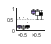

In [120]:
fig, ax = plt.subplots(figsize = (0.5,0.4))
sns.boxplot(x='dmn_by_ol', 
            y='proj_dmn_frac', 
            order = ['out', 'in'],
            data = pltdat,
            hue = 'expt_type',
            hue_order = ['in_target', 'out_target', 'WT'],
                 palette = ['mediumpurple', 'w', 'k'],
                ax = ax,
            linewidth = 0.5,
           fliersize = 0.1)
sns.despine()
ax.set_ylim([0,1])
ax.set_yticks([0, 0.5, 1])
ax.set_xticklabels(['<0.5', '>0.5'], fontsize = 5)
ax.set_yticklabels([0, 0.5, 1], fontsize = 5)
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(bottom=False, left = False, pad=-3)
ax.axhline(y = 0.5, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'DMN_proj_fraction_boxplot_by_inj_frac_in-out.pdf'), 
            bbox_inches='tight', 
            pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [121]:
formula = 'proj_dmn_frac~dmn_by_ol*C(expt_type)' 
model = ols(formula, pltdat).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
dmn_by_ol,6.8552,1.0,389.5084,0.0000
C(expt_type),0.1718,2.0,4.8814,0.0097
dmn_by_ol:C(expt_type),0.0482,2.0,1.3708,0.2591
Residual,1.6016,91.0,NaN,NaN


In [122]:
# interaction term not significant
pltdat.rename(columns = {'projection dmn fraction': 'proj_dmn_frac'}, inplace = True)
formula = 'proj_dmn_frac~dmn_by_ol+C(expt_type)' 
model = ols(formula, pltdat).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
dmn_by_ol,6.8552,1.0,386.4273,0.00
C(expt_type),0.1718,2.0,4.8428,0.01
Residual,1.6498,93.0,NaN,NaN


In [123]:
mc = MultiComparison(pltdat[(pltdat['expt_type'].isin(['in_target', 'out_target'])) &
                            (pltdat['dmn_by_ol'] == 'in')]['proj_dmn_frac'], 
                     pltdat[(pltdat['expt_type'].isin(['in_target', 'out_target'])) &
                            (pltdat['dmn_by_ol'] == 'in')]['expt_type'])
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2   meandiff p-adj  lower  upper  reject
---------------------------------------------------------
in_target out_target -0.0774  0.1151 -0.175 0.0202 False 
---------------------------------------------------------


In [124]:
mc = MultiComparison(pltdat[(pltdat['expt_type'].isin(['in_target', 'out_target'])) &
                            (pltdat['dmn_by_ol'] == 'out')]['proj_dmn_frac'], 
                     pltdat[(pltdat['expt_type'].isin(['in_target', 'out_target'])) &
                            (pltdat['dmn_by_ol'] == 'out')]['expt_type'])
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2   meandiff p-adj   lower  upper  reject
----------------------------------------------------------
in_target out_target -0.0938  0.0949 -0.2048 0.0173 False 
----------------------------------------------------------


In [125]:
pltdat.head(1)

,CAV_percent_DMN,DMN coefficient,DMN core coefficient,DMN p values,DMN t values,core distance coefficient,core p values,core t values,distance coefficient,flat_x,...,id,injection core fraction,inj_dmn_frac,injection structure,projection core fraction,proj_dmn_frac,top_x,top_y,dmn_by_ol,expt_type
0,NaN,0.082467,0.086963,[0.00000000e+000 1.85527619e-289 0.00000000e+000],[-213.54184027 36.45736686 -333.05615664],-0.013759,[0.0000000e+000 3.1407173e-279 0.0000000e+000],[-207.27327792 35.79905763 -331.41260115],-0.013887,796.0,...,126861679,0.879147,0.979492,VISam,0.583373,0.671645,396.0,741.0,in,WT


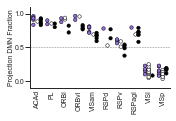

In [141]:
fig, ax = plt.subplots(1, figsize = (2.5, 1.5))
sns.stripplot('injection structure', 'proj_dmn_frac', 
            data = pltdat, 
            hue = 'expt_type', palette = [dmn_colors['in'], dmn_colors['out'], 'k'], 
            hue_order = ['in_target', 'out_target', 'WT'],
              s=3.5,
            order = plot_order, ax = ax, linewidth = 0.5,
             dodge = True, jitter = False)
ax.set_ylim([-0.1,1.1])
ax.set_xlabel(None)
ax.set_ylabel("Projection DMN Fraction", fontsize = 7, labelpad=1)
ax.tick_params(top = False, right = False, left = True, pad = 1)
ax.tick_params(axis = 'x', pad=-3)
ax.set_xticks(np.linspace(ax.get_xbound()[0]+0.5, 
                          ax.get_xbound()[1]-0.5, len(plot_order)))
plt.xticks(rotation = 90, fontsize = 7)
plt.yticks([0, 0.5, 1], fontsize = 7)
sns.despine()
ax.set_xlabel("")
ax.legend_.remove()
ax.axhline(y=0.5, xmin=0, xmax=1, color = 'grey', linestyle = 'dashed', 
           linewidth = 0.5, zorder = -1)
plt.savefig(os.path.join(savepath, 'DMN_proj_fraction_by_source_boxplot_in-out.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [142]:
in_strs = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'VISa', 'VISam', 'RSPagl',
    'RSPd', 'RSPv', 'SSp-tr', 'SSp-ll', 'MOs']
pltdat.loc[pltdat['injection structure'].isin(in_strs), 'source_type'] = 'in'
pltdat.loc[~pltdat['injection structure'].isin(in_strs), 'source_type'] = 'out'
pltdat.loc[pltdat['injection structure'].isin(in_strs), 'in_out'] = 'in'
pltdat.loc[~pltdat['injection structure'].isin(in_strs), 'in_out'] = 'out'
print(pltdat[pltdat['in_out'] == 'in']['injection structure'].unique())
print(pltdat[pltdat['in_out'] == 'out']['injection structure'].unique())
pltdat.loc[(pltdat['in_out'] == 'in') & 
           (pltdat['expt_type'] == 'in_target'), 'in_out'] = 'in_in'
pltdat.loc[(pltdat['in_out'] == 'out') & 
           (pltdat['expt_type'] == 'in_target'), 'in_out'] = 'out_in'
pltdat.loc[(pltdat['in_out'] == 'in') & 
           (pltdat['expt_type'] == 'out_target'), 'in_out'] = 'in_out'
pltdat.loc[(pltdat['in_out'] == 'out') & 
           (pltdat['expt_type'] == 'out_target'), 'in_out'] = 'out_out'

['VISam' 'ACAd' 'RSPagl' 'RSPv' 'ORBvl' 'ORBl' 'PL' 'RSPd']
['VISp' 'VISl']


In [143]:
type_order = ['in_in', 'in_out', 'in',  '', 'out_in', 'out_out', 'out']

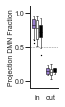

In [145]:
fig, ax = plt.subplots(1, figsize = (0.5, 1.5))
sns.boxplot('in_out', 'proj_dmn_frac',
              data = pltdat, order = type_order,
              hue = 'in_out',
              hue_order = type_order,
              linewidth = 0.5, ax = ax,  
              palette = [dmn_colors['in'], dmn_colors['out'], 'k', 'k'],
             fliersize = 0.5, dodge = False)
ax.set_xlim([-1, 7])
ax.set_ylim([-0.1,1.1])
plt.xticks([1, 5], fontsize = 7, labels = ['in', 'out'])
plt.yticks([0, 0.5, 1], fontsize = 7)
ax.set_ylabel("Projection DMN Fraction", fontsize = 7)
ax.yaxis.labelpad = 1
sns.despine()
ax.set_xlabel("")
ax.legend_.remove()
ax.axhline(y=0.5, xmin=0, xmax=1, color = 'grey', linestyle = 'dashed', 
           linewidth = 0.5, zorder = -1)
ax.tick_params(top = False, right = False, left = True, pad = 1)
ax.axhline(y=50, xmin=0, xmax=100, color = 'grey', linestyle = 'dashed', 
           linewidth = 0.5, zorder = -1)
plt.savefig(os.path.join(savepath, 'DMN_proj_boxplot_wt-out-in.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [146]:
formula = 'proj_dmn_frac~C(source_type)*C(expt_type)' 
model = ols(formula, pltdat).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(source_type),7.3004,1.0,564.5899,0.0000
C(expt_type),0.0850,2.0,3.2855,0.0419
C(source_type):C(expt_type),0.0279,2.0,1.0792,0.3442
Residual,1.1767,91.0,NaN,NaN


In [147]:
# interaction term not significant
formula = 'proj_dmn_frac~C(source_type)+C(expt_type)' 
model = ols(formula, pltdat).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(source_type),7.3004,1.0,563.6295,0.000
C(expt_type),0.0850,2.0,3.2800,0.042
Residual,1.2046,93.0,NaN,NaN


In [148]:
pltdat['source_type'].unique()

array(['in', 'out'], dtype=object)

In [149]:
stats.shapiro(model.resid)

(0.969099760055542, 0.02179638110101223)

In [150]:
mc = MultiComparison(pltdat[(pltdat['expt_type'].isin(['in_target', 'out_target'])) &
                            (pltdat['source_type'] == 'in')]['proj_dmn_frac'], 
                     pltdat[(pltdat['expt_type'].isin(['in_target', 'out_target'])) &
                            (pltdat['source_type'] == 'in')]['expt_type'])
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2   meandiff p-adj   lower  upper  reject
----------------------------------------------------------
in_target out_target -0.0588  0.2751 -0.1669 0.0493 False 
----------------------------------------------------------


In [151]:
mc = MultiComparison(pltdat[(pltdat['expt_type'].isin(['in_target', 'out_target'])) &
                            (pltdat['source_type'] == 'out')]['proj_dmn_frac'], 
                     pltdat[(pltdat['expt_type'].isin(['in_target', 'out_target'])) &
                            (pltdat['source_type'] == 'out')]['expt_type'])
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2   meandiff p-adj  lower  upper  reject
---------------------------------------------------------
in_target out_target  -0.024  0.2824 -0.069 0.0209 False 
---------------------------------------------------------


In [152]:
def assign_module(df):
    df.loc[df['structure_abbrev'].isin(['ACAd', 'ACAv', 'ORBl','ORBm', 'ORBvl', 
                                                    'ILA', 'PL', 'FRP']), 'module'] = 'Prefrontal'
    df.loc[df['structure_abbrev'].isin(['VISam', 'RSPagl', 'RSPv', 'VISpm',
                                                    'VISa', 'RSPd']), 'module'] = 'Medial'
    df.loc[df['structure_abbrev'].isin(['SSp-tr', 'SSp-ll', 'SSp-bfd', 'SSp-un',
                                                    'SSp-ul', 'MOs', 'MOp', 'SSs', 'SSp-n',
                                                    'SSp-m']), 'module'] = 'Somatomotor'
    df.loc[df['structure_abbrev'].isin(['VISal', 'VISl', 'VISli', 'VISp', 'VISpl',
                                                    'VISpor', 'VISrl']), 'module'] = 'Visual'
    df.loc[df['structure_abbrev'].isin(['AUDpo', 'AUDd', 'AUDp', 'AUDv']), 
                    'module'] = 'Auditory'
    df.loc[df['structure_abbrev'].isin(['TEa', 'PERI', 'ECT', 'GU', 'AId', 'AIv',
                                                    'AIp', 'VISC']), 'module'] = 'Lateral'
    print(len(df[df['module'].isnull()]))
    return df

In [153]:
pltdat['structure_abbrev'] = pltdat['injection structure']
pltdat = assign_module(pltdat)

0


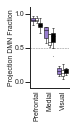

In [155]:
mod_order = ['Prefrontal', 'Medial', 'Visual']
fig, ax = plt.subplots(1, figsize = (0.7, 1.5))
sns.boxplot('module', 'proj_dmn_frac', data = pltdat, 
            order = mod_order, ax = ax, 
            hue = 'expt_type', hue_order = ['in_target', 'out_target', 'WT'],
            palette = [dmn_colors['in'], dmn_colors['out'], 'k', 'k'], 
            fliersize = 0.1, linewidth = 0.5)
ax.tick_params(top = False, right = False)
ax.set_ylim([-0.1, 1.1])
plt.yticks([0, 0.5, 1], fontsize = 7)
plt.xticks(rotation = 90, fontsize = 7)
#plt.title('Intra-DMN', fontsize = 10, y=0.96)
ax.set_xlabel("")
ax.set_ylabel("Projection DMN Fraction", fontsize = 7)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 8
ax.tick_params(top = False, right = False, left = True, bottom = False, pad = 1)
ax.tick_params(axis = 'x', pad=-3)
ax.legend_.remove()
sns.despine()
ax.axhline(y=0.5, xmin=0, xmax=1, color = 'grey', linestyle = 'dashed', 
           linewidth = 0.5, zorder = -1)
plt.savefig(os.path.join(savepath, 'DMN_proj_by_module_and_target_boxplot_horizontal.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [67]:
formula = 'proj_dmn_frac~C(module)*C(expt_type)' 
model = ols(formula, pltdat).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(module),7.9949,2.0,758.5728,0.0000
C(expt_type),0.0608,2.0,5.7713,0.0044
C(module):C(expt_type),0.0463,4.0,2.1986,0.0756
Residual,0.4637,88.0,NaN,NaN


In [125]:
pltdat['expt_type'].unique()

array(['WT', 'in_target', 'out_target'], dtype=object)

In [126]:
#interaction term not significant
formula = 'proj_dmn_frac~C(module)+C(expt_type)' 
model = ols(formula, pltdat[pltdat['expt_type'].isin(['in_target', 'out_target'])]).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(module),6.1028,2.0,683.5002,0.0000
C(expt_type),0.0203,1.0,4.5573,0.0372
Residual,0.2500,56.0,NaN,NaN


In [128]:
mc = MultiComparison(pltdat[pltdat['expt_type'].isin(['in_target', 'out_target'])]['proj_dmn_frac'], 
                     pltdat[pltdat['expt_type'].isin(['in_target', 'out_target'])]['module'])
mc_results = mc.tukeyhsd()
print(mc_results)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
  Medial   Prefrontal  0.2257  0.001  0.1661  0.2852  True 
  Medial     Visual   -0.5428  0.001 -0.5955 -0.4901  True 
Prefrontal   Visual   -0.7684  0.001  -0.82  -0.7168  True 
-----------------------------------------------------------


In [129]:
mc = MultiComparison(pltdat[(pltdat['expt_type'].isin(['in_target', 'out_target'])) &
                             (pltdat['module'] == 'Prefrontal')]['proj_dmn_frac'], 
                     pltdat[(pltdat['expt_type'].isin(['in_target', 'out_target'])) &
                             (pltdat['module'] == 'Prefrontal')]['expt_type'])
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2   meandiff p-adj   lower  upper  reject
----------------------------------------------------------
in_target out_target  0.0048  0.8378 -0.0431 0.0527 False 
----------------------------------------------------------


In [130]:
mc = MultiComparison(pltdat[(pltdat['expt_type'].isin(['in_target', 'out_target'])) &
                            (pltdat['module'] == 'Medial')]['proj_dmn_frac'], 
                     pltdat[(pltdat['expt_type'].isin(['in_target', 'out_target'])) &
                            (pltdat['module'] == 'Medial')]['expt_type'])
mc_results = mc.tukeyhsd()
print(mc_results)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2   meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
in_target out_target -0.1135  0.0428 -0.2228 -0.0043  True 
-----------------------------------------------------------


In [131]:
mc = MultiComparison(pltdat[(pltdat['expt_type'].isin(['in_target', 'out_target'])) &
                            (pltdat['module'] == 'Visual')]['proj_dmn_frac'], 
                     pltdat[(pltdat['expt_type'].isin(['in_target', 'out_target'])) &
                            (pltdat['module'] == 'Visual')]['expt_type'])
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2   meandiff p-adj  lower  upper  reject
---------------------------------------------------------
in_target out_target  -0.024  0.2824 -0.069 0.0209 False 
---------------------------------------------------------


In [104]:
paireddat = pltdat.groupby(['structure_abbrev', 'expt_type']).mean().reset_index()
#paireddat = paireddat[paireddat['expt_type'].isin(['in_target', 'out_target'])]

In [105]:
paireddat

,structure_abbrev,expt_type,CAV_percent_DMN,DMN coefficient,DMN core coefficient,core distance coefficient,distance coefficient,flat_x,flat_y,flipped_flat_x,id,injection core fraction,inj_dmn_frac,projection core fraction,proj_dmn_frac,top_x,top_y
0,ACAd,WT,NaN,0.218329,0.305947,-0.003930,-0.005744,315.000000,823.333333,315.000000,3.742480e+08,0.999890,0.999890,0.851792,0.885737,569.666667,463.000000
1,ACAd,in_target,99.481307,0.036602,0.059099,-0.002543,-0.003018,319.000000,703.000000,NaN,5.580706e+08,0.999349,0.999349,0.890369,0.914535,569.000000,473.600000
2,ACAd,out_target,10.329886,0.006696,0.012143,-0.000869,-0.000984,NaN,NaN,NaN,6.094759e+08,1.000000,1.000000,0.863241,0.894676,569.000000,470.000000
3,ORBl,WT,NaN,0.157332,0.118176,-0.011713,-0.011239,NaN,NaN,NaN,1.345241e+08,0.910837,0.978525,0.629173,0.771007,771.500000,198.000000
4,ORBl,in_target,96.642483,0.041540,0.047082,-0.002241,-0.002226,174.000000,722.000000,NaN,5.721037e+08,0.990809,0.999828,0.813517,0.902225,345.500000,214.000000
5,ORBl,out_target,1.683044,0.005508,0.007615,-0.000277,-0.000286,NaN,NaN,NaN,6.193023e+08,0.981140,1.000000,0.878514,0.924342,351.500000,204.500000
6,ORBvl,WT,NaN,0.231028,0.242439,-0.002924,-0.002733,NaN,NaN,NaN,2.599055e+08,0.990614,0.995993,0.710610,0.796151,645.750000,198.000000
7,ORBvl,in_target,99.845403,0.025326,0.029306,-0.000942,-0.000942,NaN,NaN,NaN,5.485071e+08,1.000000,1.000000,0.877730,0.935647,474.500000,204.000000
8,ORBvl,out_target,6.032285,0.006041,0.009573,-0.000384,-0.000405,146.000000,836.000000,NaN,6.179001e+08,1.000000,1.000000,0.943738,0.958065,378.000000,195.000000
9,PL,WT,NaN,0.063749,0.070069,-0.005970,-0.005971,NaN,NaN,NaN,2.104089e+08,1.000000,1.000000,0.748060,0.825987,572.000000,226.000000


In [106]:
formula = 'proj_dmn_frac~C(structure_abbrev)*C(expt_type)' 
model = ols(formula, pltdat).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(structure_abbrev),8.2117,9.0,332.2029,0.0000
C(expt_type),0.0692,2.0,12.5949,0.0000
C(structure_abbrev):C(expt_type),0.1093,18.0,2.2105,0.0102
Residual,0.1840,67.0,NaN,NaN


In [107]:
from statsmodels.stats.anova import AnovaRM
aovrm2way = AnovaRM(paireddat, 'proj_dmn_frac', 'structure_abbrev', within=['expt_type'])
res2way = aovrm2way.fit()

print(res2way)

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
expt_type  5.4189 2.0000 18.0000 0.0144



In [115]:
aovrm2way = AnovaRM(pltdat, 'proj_dmn_frac', 'structure_abbrev', within=['expt_type'],
                   aggregate_func = 'mean')
res2way = aovrm2way.fit()

print(res2way)

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
expt_type  5.4189 2.0000 18.0000 0.0144



In [117]:
pltdat.keys()

Index(['CAV_percent_DMN', 'DMN coefficient', 'DMN core coefficient',
       'DMN p values', 'DMN t values', 'core distance coefficient',
       'core p values', 'core t values', 'distance coefficient', 'flat_x',
       'flat_y', 'flipped_flat_x', 'id', 'injection core fraction',
       'inj_dmn_frac', 'injection structure', 'projection core fraction',
       'proj_dmn_frac', 'top_x', 'top_y', 'dmn_by_ol', 'expt_type',
       'source_type', 'in_out', 'structure_abbrev', 'module'],
      dtype='object')

In [118]:
aovrm2way = AnovaRM(pltdat[pltdat['module'] == 'Prefrontal'], 
                    'proj_dmn_frac', 'structure_abbrev', within=['expt_type'],
                   aggregate_func = 'mean')
res2way = aovrm2way.fit()

print(res2way)

                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
expt_type  6.2857 2.0000 6.0000 0.0337



In [124]:
aovrm2way = AnovaRM(pltdat[pltdat['module'] == 'Medial'], 
                    'proj_dmn_frac', 'structure_abbrev', within=['expt_type'],
                   aggregate_func = 'mean')
res2way = aovrm2way.fit()

print(res2way)

                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
expt_type  5.0811 2.0000 6.0000 0.0512



In [121]:
aovrm2way = AnovaRM(pltdat[pltdat['module'] == 'Visual'], 
                    'proj_dmn_frac', 'structure_abbrev', within=['expt_type'],
                   aggregate_func = 'mean')
res2way = aovrm2way.fit()

print(res2way)

                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
expt_type  0.2564 2.0000 2.0000 0.7959

